In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from PIL import Image
import yaml
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda:1'

In [2]:
from enum import Enum, unique

class Curvature(Enum):
    NO_CURVATURE = False
    CURVATURE = True


/tmp/ipykernel_7636/1539602785.py:11: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  map_img = np.array(Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)


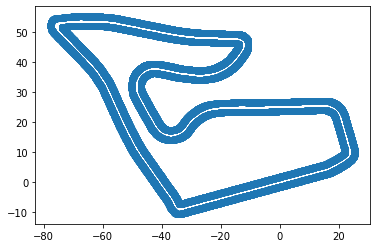

In [3]:
def _get_map_points(map_path, map_ext):
    with open(map_path + '.yaml', 'r') as yaml_stream:
        try:
            map_metadata = yaml.safe_load(yaml_stream)
            map_resolution = map_metadata['resolution']
            origin = map_metadata['origin']
            origin_x = origin[0]
            origin_y = origin[1]
        except yaml.YAMLError as ex:
            print(ex)
    map_img = np.array(Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)
    map_height = map_img.shape[0]
    map_width = map_img.shape[1]

    # convert map pixels to coordinates
    range_x = np.arange(map_width)
    range_y = np.arange(map_height)
    map_x, map_y = np.meshgrid(range_x, range_y)
    map_x = (map_x * map_resolution + origin_x).flatten()
    map_y = (map_y * map_resolution + origin_y).flatten()
    map_z = np.zeros(map_y.shape)
    map_coords = np.vstack((map_x, map_y, map_z))

    # mask and only leave the obstacle points
    map_mask = map_img == 0.0
    map_mask_flat = map_mask.flatten()
    map_points = map_coords[:, map_mask_flat].T
    return map_points[:,0], map_points[:,1]

map_x, map_y = _get_map_points("../data_generation/track_config/Spielberg_map", ".png")
plt.scatter(map_x, map_y)

In [4]:
from tensorboardX import SummaryWriter


In [5]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
full_frame = pd.read_pickle("../../data/final_data.pkl")

In [6]:
torch.tensor(np.array(train_frame.iloc[:9]['input_no_curve'].to_list())).shape

torch.Size([9, 10, 3])

In [7]:
class TraceRelativeDataset(Dataset):
    def __init__(self, dataframe, curve=False):
        self.dataframe = dataframe
        self.curve = curve

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.curve:
            key="input"
        else:
            key="input_no_curve"
        
        try:
            inputs = torch.tensor(np.array(self.dataframe.iloc[idx][key].to_list()), dtype=torch.float32)
            last_pose = torch.tensor(np.array(self.dataframe.iloc[idx]['last_pose'].to_list()), dtype=torch.float32)
            target = torch.tensor(np.array(self.dataframe.iloc[idx]['target'].to_list()), dtype=torch.float32)
        except AttributeError as v:
            inputs = torch.tensor(self.dataframe.iloc[idx][key], dtype=torch.float32)
            last_pose = torch.tensor(self.dataframe.iloc[idx]['last_pose'], dtype=torch.float32)
            target = torch.tensor(self.dataframe.iloc[idx]['target'], dtype=torch.float32)
        return inputs, last_pose, target

train_dataset = TraceRelativeDataset(train_frame, curve=True)
test_dataset = TraceRelativeDataset(test_frame, curve=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
print(len(train_dataset), " in train")
print(len(test_dataset), " in test")

2302  in train
576  in test


In [13]:
def bicycle_model_eval(inputs, last_poses):
    # This version takes in an input of dim 5
    BATCHES = inputs.shape[0]
    states = []  # torch.zeros((81, 4))
    L = 0.3302
    TS = 0.1
    X, Y, THETA, V = 0, 1, 2, 3
    state = torch.zeros((BATCHES, 4,))
    state[:,X] = last_poses[:,0]
    state[:,Y] = last_poses[:,1]
    state[:,THETA] = last_poses[:,2]
    state[:,V] = inputs[:,0]
    states.append(state)
    for i in range(1,81):
        # Advance bicycle model
        state = torch.zeros((BATCHES, 4,))
        state[:,X] = states[i-1][:,X] + (TS * states[i-1][:,V] * torch.cos(states[i-1][:,THETA]))
        state[:,Y] = states[i-1][:,Y] + (TS * states[i-1][:,V] * torch.sin(states[i-1][:,THETA]))
        state[:,THETA] = states[i-1][:,THETA] + (TS * (states[i-1][:,V] * torch.tan(inputs[:,1])) / L)
        state[:,V] = states[i-1][:,V] + TS*inputs[:,2]
        states.append(state)
    trace = torch.dstack(states).movedim((0,1,2), (0,2,1))
    trace = trace[:,1:,:3]
    return trace

def custom_loss_func(prediction, target):
    loss = F.smooth_l1_loss(prediction[:,:,:2], target[:,:,:2])
    loss += 4*F.smooth_l1_loss(prediction[:,:,2], target[:,:,2])
    #loss += 10*output[0]**2 if output[0]<0 else 0
    #loss += 2*torch.linalg.norm(output)**2
    return loss

def average_displacement_error(prediction, target):
    loss = torch.linalg.norm(prediction[:,:,:2]-target[:,:,:2], dim=2)
    ade = torch.mean(loss, dim=0)
    return torch.sum(ade)

def final_displacement_error(prediction, target):
    loss = torch.linalg.norm(prediction[:,-1,:2]-target[:,-1,:2], dim=1)
    return torch.sum(loss)

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, horizon=60):
        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.horizon = horizon
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=4, batch_first=True)
        
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.Linear(hidden_dim//2, 3*horizon)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        output = output[:,-1].reshape((inputs.shape[0], self.horizon, 3))
        return output
    
    def predict(self, inputs, last_poses, horizon=60):
        residuals =  self.forward(inputs)
        last_poses = last_poses.to(DEVICE)
        outputs = torch.tile(last_poses.reshape(last_poses.shape[0],1,last_poses.shape[1]), 
                             (1,60,1))
        
        outputs = outputs[:,:,:3]
        outputs = residuals+outputs
        return outputs
        

class LSTMPredictorBicycle(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, control_outputs=1):
        super(LSTMPredictorBicycle, self).__init__()
        self.hidden_dim = hidden_dim
        self.control_outputs = control_outputs

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=4, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.Linear(hidden_dim//2, 1+control_outputs*2)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        scaled_output = list()
        scaled_output.append(F.softplus(output[:,:,0]))
        for step in range(self.control_outputs):
            scaled_output.append(torch.tanh(output[:,:,(step*2)+1])*np.pi)
            scaled_output.append(output[:,:,(step*2)+2])
        output = torch.dstack(scaled_output)
        return output
    
    def predict(self, inputs, last_poses, horizon=60):
        # Compute LSTM output
        controls = self.forward(inputs)[:, -1]  # Take last prediction
        last_poses = last_poses.to(DEVICE)
        BATCHES = controls.shape[0]
        states = []  # torch.zeros((81, 4))
        L = 0.3302
        TS = 0.1
        X, Y, THETA, V = 0, 1, 2, 3
        CDIMS = 2
        state = torch.zeros((BATCHES, 4,), device=DEVICE)
        state[:,X] = last_poses[:,0]
        state[:,Y] = last_poses[:,1]
        state[:,THETA] = last_poses[:,2]
        state[:,V] = controls[:,0]
        states.append(state)
        step_length = horizon//self.control_outputs
        for i in range(1,horizon+1):
            # Advance bicycle model
            step = min((i-1)//step_length, self.control_outputs-1)
            state = torch.zeros((BATCHES, 4,), device=DEVICE)
            state[:,X] = states[i-1][:,X] + (TS * states[i-1][:,V] * torch.cos(states[i-1][:,THETA]))
            state[:,Y] = states[i-1][:,Y] + (TS * states[i-1][:,V] * torch.sin(states[i-1][:,THETA]))
            state[:,THETA] = states[i-1][:,THETA] + (TS * (states[i-1][:,V] * torch.tan(controls[:,(step*CDIMS)+1])) / L)
            state[:,V] = states[i-1][:,V] + TS*controls[:,(step*CDIMS)+2]
            states.append(state)
        trace = torch.dstack(states).movedim((0,1,2), (0,2,1))
        trace = trace[:,1:,:3]
        return trace

In [14]:
60//8

7

In [15]:
def create_debug_plot(net, train_dataset:TraceRelativeDataset=train_dataset, test_dataset:TraceRelativeDataset=test_dataset, curvature:Curvature=Curvature.NO_CURVATURE):
    selection = [1912, 2465, 533, 905, 277, 1665, 2395, 61, 1054]
    inputs, last_poses, targets = train_dataset[:len(selection)]
    inputs = torch.zeros_like(inputs, dtype=torch.float32, device=DEVICE)
    last_poses = torch.zeros_like(last_poses, dtype=torch.float32, device=DEVICE)
    for i, DATA_IDX in enumerate(selection):
        data_in_train = True if DATA_IDX in train_frame.index else False
        if data_in_train:
            dframe = train_frame
        else:
            dframe = test_frame
        if curvature is Curvature.NO_CURVATURE:
            inputs[i] = torch.tensor(dframe.loc[DATA_IDX]['input_no_curve'], dtype=torch.float32, device=DEVICE)
        else:
            inputs[i] = torch.tensor(dframe.loc[DATA_IDX]['input'], dtype=torch.float32, device=DEVICE)
        last_poses[i] = torch.tensor(dframe.loc[DATA_IDX]['last_pose'], dtype=torch.float32, device=DEVICE)
        targets[i] = torch.tensor(dframe.loc[DATA_IDX]['target'], dtype=torch.float32, device=DEVICE)
    outputs = net.predict(inputs, last_poses).detach().cpu().numpy()

    fig, axs = plt.subplots(3,3,figsize=(10,10), dpi=300)
    for idx, DATA_IDX in enumerate(selection):
        data_in_train = True if DATA_IDX in train_frame.index else False
        if data_in_train:
            dframe = train_frame
        else:
            dframe = test_frame
        linput, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['input'][:,0], dframe.loc[DATA_IDX]['input'][:,1], marker='.', label="Input")
        ltarget, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['target'][:,0], dframe.loc[DATA_IDX]['target'][:,1], marker='.', label="Target")
        lpred, = axs[idx//3, idx%3].plot(outputs[idx,:,0], outputs[idx,:,1], marker='x', label="Prediction")
        xlim, ylim = np.average(axs[idx//3, idx%3].get_xlim()), np.average(axs[idx//3, idx%3].get_ylim())
        axs[idx//3, idx%3].scatter(map_x, map_y, marker=".", color='black')
        axs[idx//3, idx%3].set(xlim=(xlim-3.5,xlim+3.5),
                               ylim=(ylim-3.5,ylim+3.5),
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[])
        axs[idx//3, idx%3].set_title("{}:{}".format("Train" if data_in_train else "Test",DATA_IDX))
    fig.suptitle("Manually Selected Traces")
    fig.legend(handles=[linput, ltarget, lpred])
    return fig, axs

In [51]:
def plot_single_scenario(input, output, target, title=""):
    fig, ax = plt.subplots(1,1,figsize=(5,5), dpi=300)
    input = input.detach().cpu().numpy()
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    linput = ax.plot(input[:,0], input[:,1], marker='.', label="Input")
    ltarget = ax.plot(target[:,0], target[:,1], marker='.', label="Target")
    lpred = ax.plot(output[:,0], output[:,1], marker='o', label="Prediction")
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.scatter(map_x, map_y, marker=".", color='black')
    ax.set(xlim=xlim,
           ylim=ylim,
           aspect=1.0,
           adjustable='box',
           yticklabels=[],
           xticklabels=[])
    ax.set_title(title)

In [64]:
net = LSTMPredictor(input_dim=9, hidden_dim=16)
net.to(DEVICE)
net.load_state_dict(torch.load("runs/toy/lstm-baseline/LSTM-CURVATURE-16-P10156/best_model.pt"))
for input, last_pose, target in train_dataloader:
    break;
display(input.shape)
display(last_pose.shape)
display(target.shape)
input = input.to(DEVICE)
last_pose = last_pose.to(DEVICE)
other_outp = net.predict(input, last_pose)
other_outp.shape

torch.Size([32, 10, 9])

torch.Size([32, 4])

torch.Size([32, 60, 3])

torch.Size([32, 60, 3])

In [65]:
torch.tile(last_pose.reshape(last_pose.shape[0],1,last_pose.shape[1]), (1,60,1)).shape

torch.Size([32, 60, 4])

0.3561999797821045

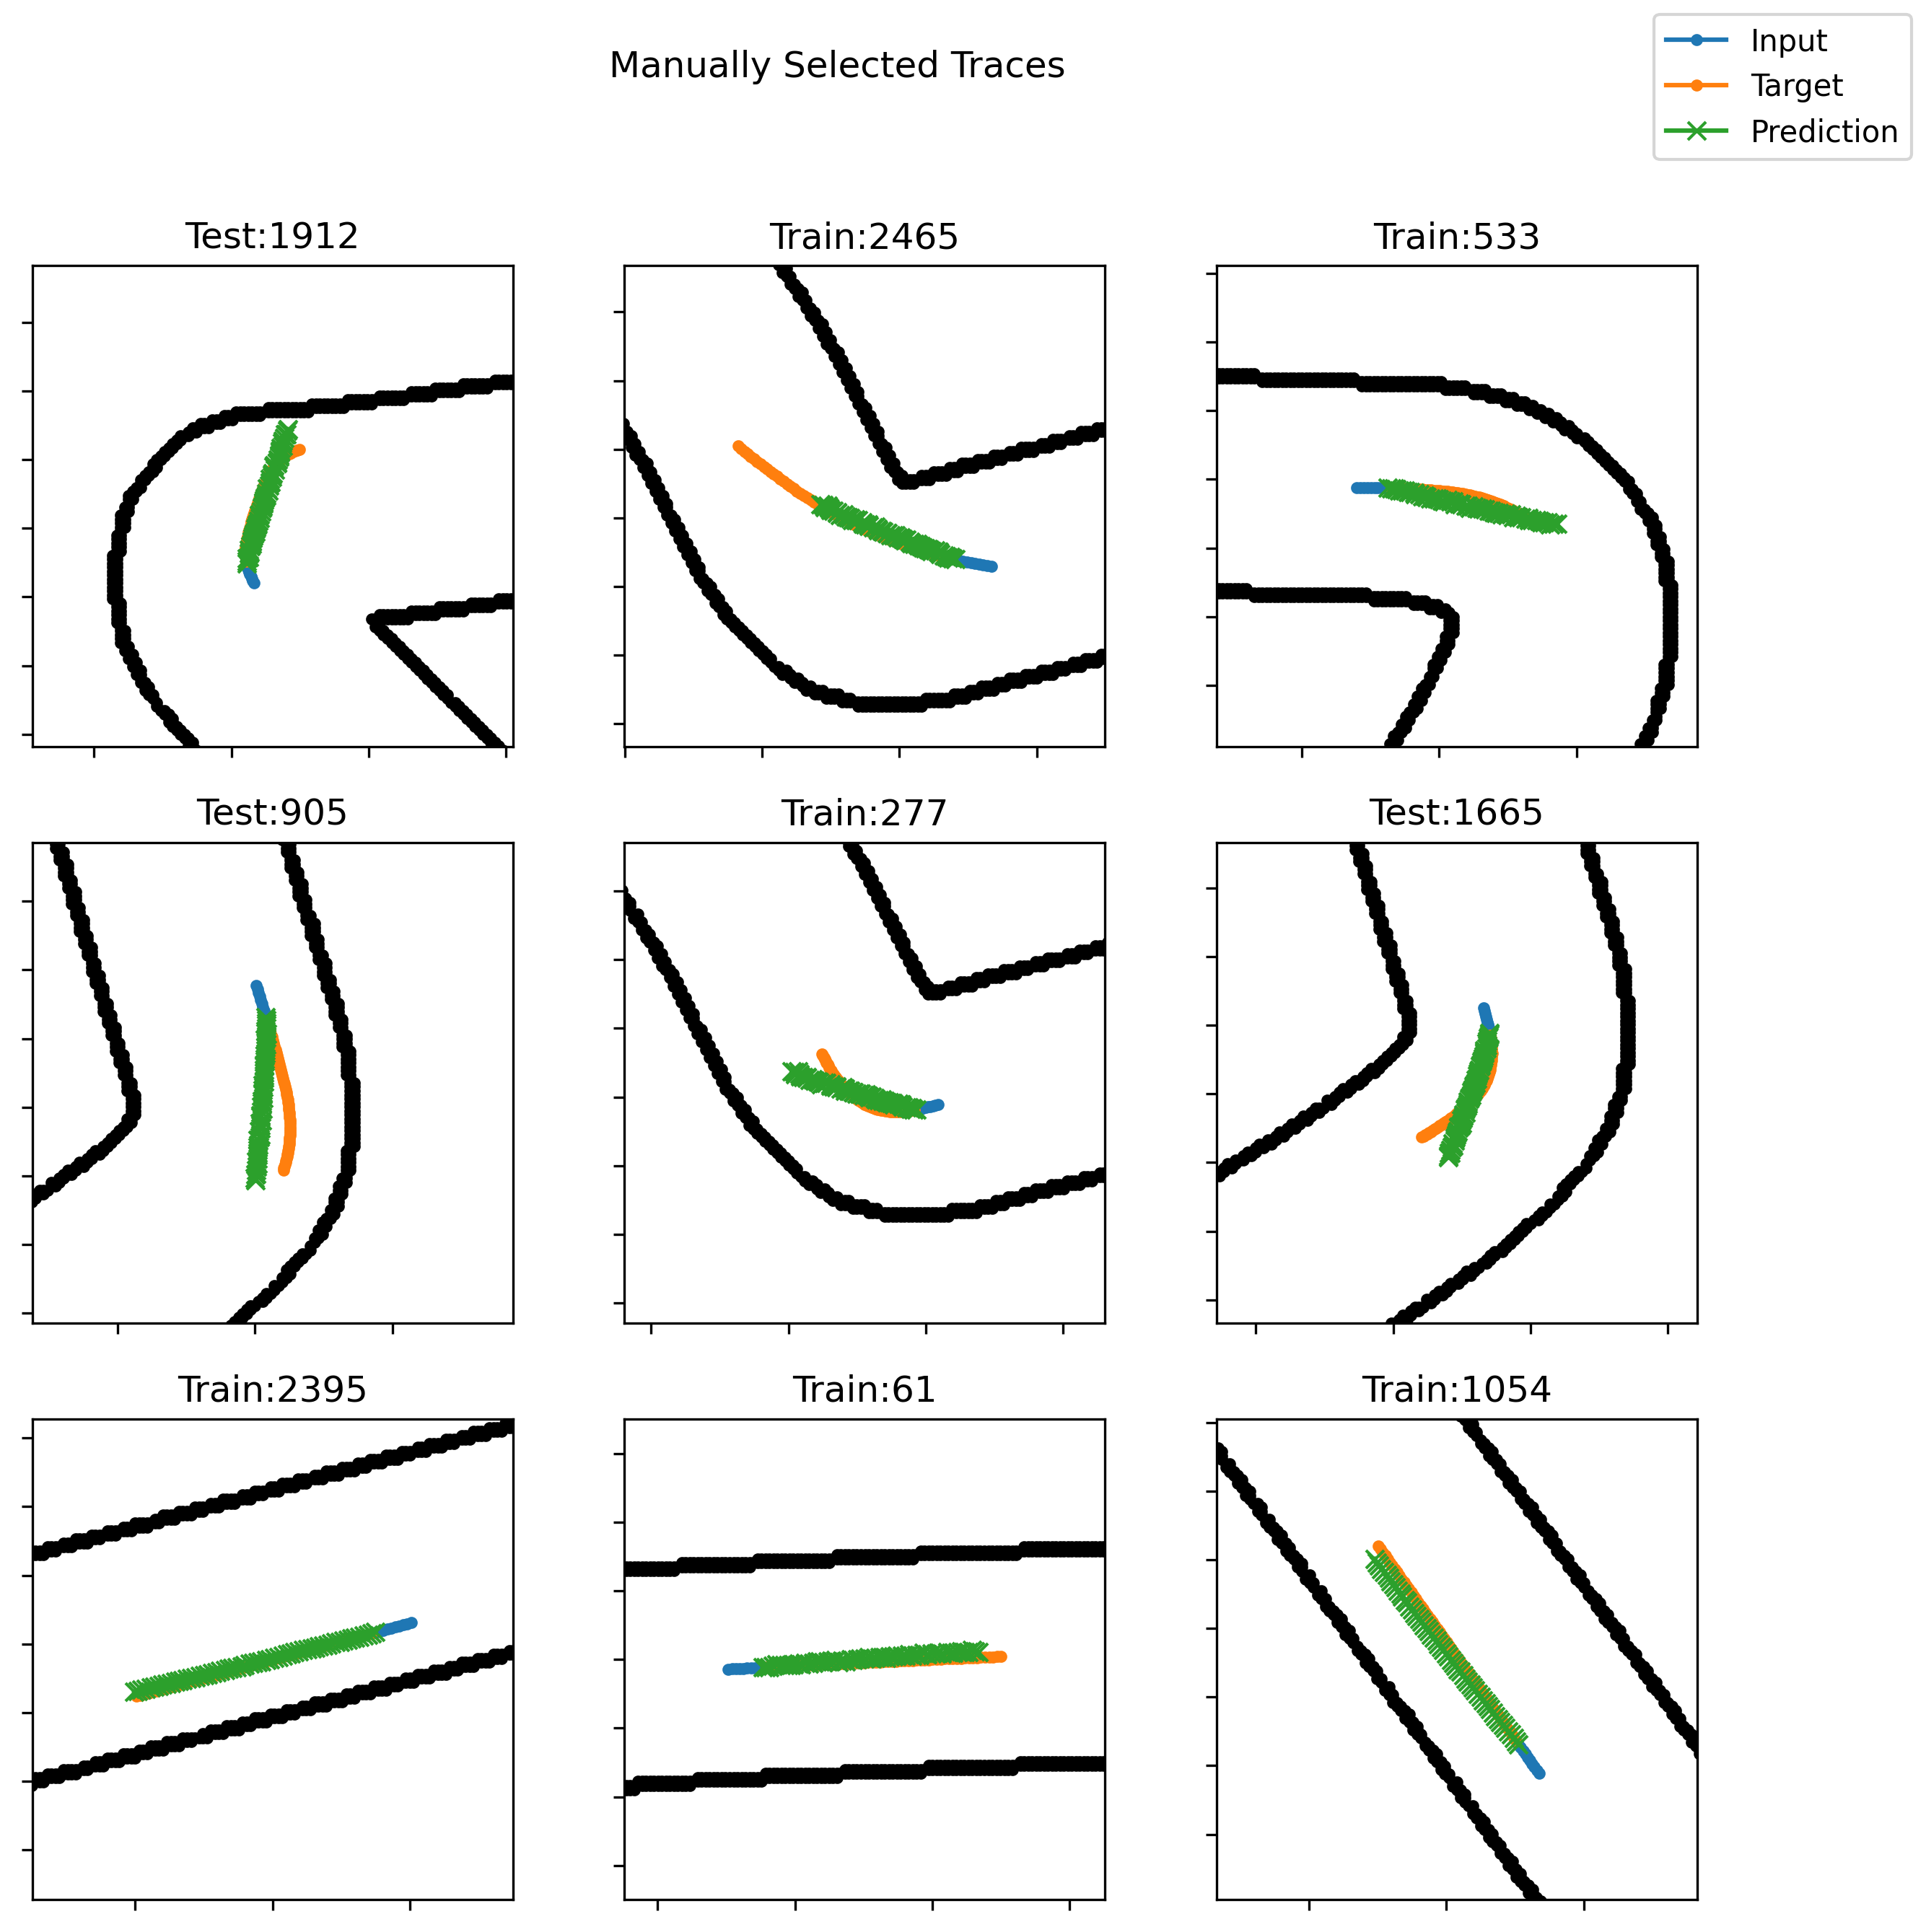

In [66]:
import time
start = time.time()
create_debug_plot(net, curvature=Curvature.CURVATURE)
end = time.time()
end-start

In [67]:
lstm_ades = list()
lstm_fdes = list()
lstm_errors = list()
for input, last_pose, target in tqdm(test_dataset):
    with torch.no_grad():
        input = input.unsqueeze(0).to(DEVICE)
        last_pose = last_pose.unsqueeze(0)
        target = target.unsqueeze(0).to(DEVICE)
        output = net.predict(input, last_pose)
        loss = custom_loss_func(output, target)
        lstm_errors.append(loss.item())
        ade = average_displacement_error(output, target)
        lstm_ades.append(ade.item())
        fde = final_displacement_error(output, target)
        lstm_fdes.append(fde.item())
        

  0%|          | 0/576 [00:00<?, ?it/s]

Min: 0.0004460551426745951 Max: 21.11429786682129, StdDev:1.8665718486725627


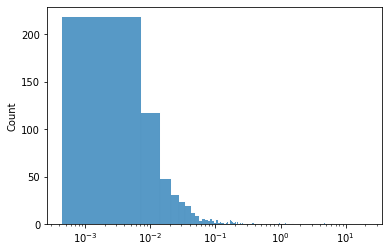

In [68]:
import seaborn as sns
ax = sns.histplot(lstm_errors)
ax.set_xscale("log")
print(f"Min: {min(lstm_errors)} Max: {max(lstm_errors)}, StdDev:{np.std(lstm_errors)}")

Min: 0.012482378631830215 Max: 1.665197730064392, StdDev:0.2682226380278132


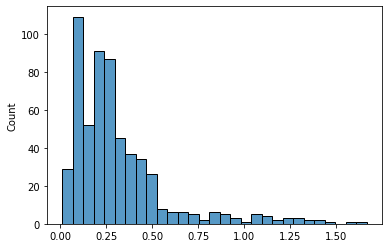

In [69]:
ax = sns.histplot(lstm_fdes)
#ax.set_xscale("log")
print(f"Min: {min(lstm_fdes)} Max: {max(lstm_fdes)}, StdDev:{np.std(lstm_fdes)}")

Min: 1.4534080028533936 Max: 53.67424774169922, StdDev:7.890741029773381


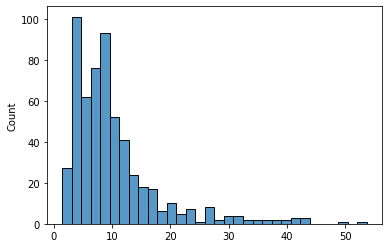

In [70]:
ax = sns.histplot(lstm_ades)
#ax.set_xscale("log")
print(f"Min: {min(lstm_ades)} Max: {max(lstm_ades)}, StdDev:{np.std(lstm_ades)}")

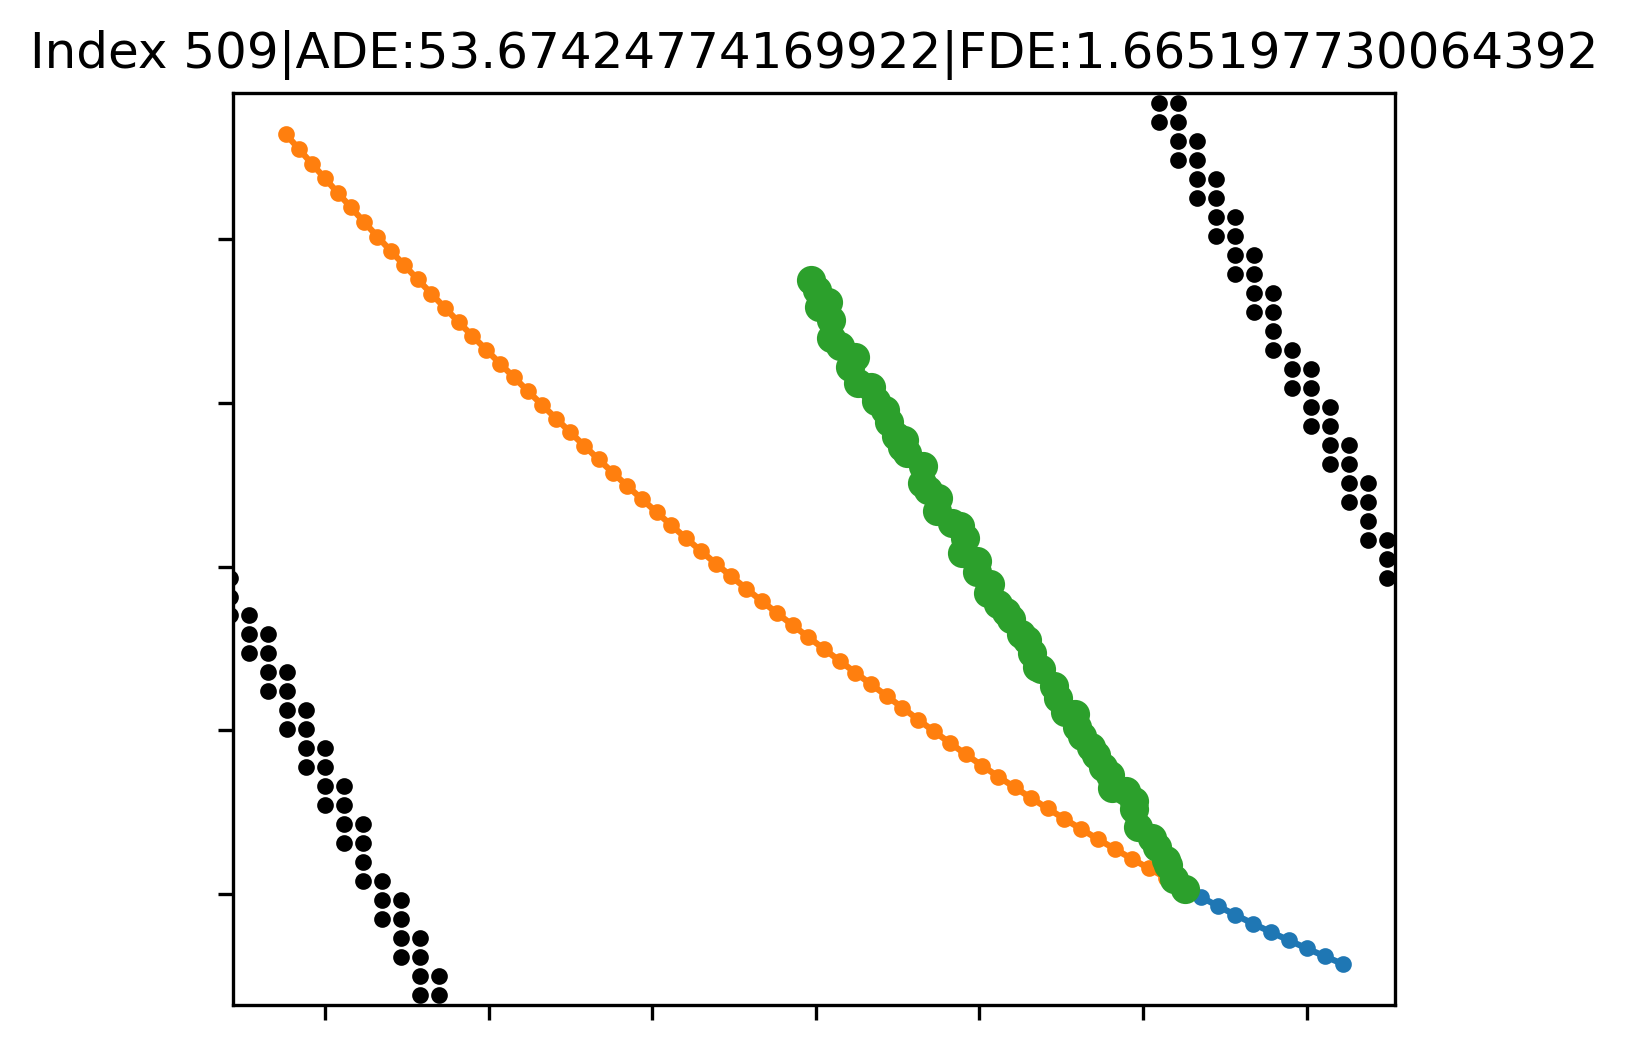

In [71]:
worst_index = np.argmax(lstm_ades)
input, last_pose, target = test_dataset[worst_index]
with torch.no_grad():
    input = input.unsqueeze(0).to(DEVICE)
    last_pose = last_pose.unsqueeze(0)
    target = target.unsqueeze(0).to(DEVICE)
    output = net.predict(input, last_pose)
    loss = custom_loss_func(output, target)
    ade = average_displacement_error(output, target)
    fde = final_displacement_error(output, target)
    plot_single_scenario(input[0], output[0], target[0], title=f"Index {worst_index}|ADE:{ade}|FDE:{fde}")

In [72]:
net = LSTMPredictorBicycle(input_dim=9, hidden_dim=16, control_outputs=10)
net.to(DEVICE)
net.load_state_dict(torch.load("runs/toy/hyp-search/bicycle-10-CURVATURE-16/best_model.pt"))
for input, last_pose, target in train_dataloader:
    break;
display(input.shape)
display(last_pose.shape)
display(target.shape)
input = input.to(DEVICE)
last_pose = last_pose.to(DEVICE)
other_outp = net.predict(input, last_pose)
other_outp.shape

torch.Size([32, 10, 9])

torch.Size([32, 4])

torch.Size([32, 60, 3])

torch.Size([32, 60, 3])

In [73]:
pimp_ades = list()
pimp_fdes = list()
pimp_errors = list()
for input, last_pose, target in tqdm(test_dataset):
    with torch.no_grad():
        input = input.unsqueeze(0).to(DEVICE)
        last_pose = last_pose.unsqueeze(0)
        target = target.unsqueeze(0).to(DEVICE)
        output = net.predict(input, last_pose)
        loss = custom_loss_func(output, target)
        pimp_errors.append(loss.item())
        ade = average_displacement_error(output, target)
        pimp_ades.append(ade.item())
        fde = final_displacement_error(output, target)
        pimp_fdes.append(fde.item())
        

  0%|          | 0/576 [00:00<?, ?it/s]

Min: 0.0007887111278250813 Max: 17.023521423339844, StdDev:1.7503329926056233


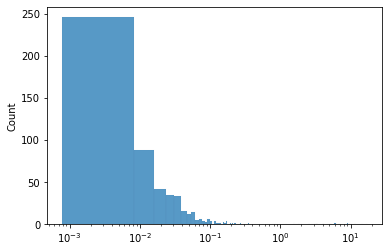

In [74]:
import seaborn as sns
ax = sns.histplot(pimp_errors)
ax.set_xscale("log")
print(f"Min: {min(pimp_errors)} Max: {max(pimp_errors)}, StdDev:{np.std(pimp_errors)}")

Min: 0.013192396610975266 Max: 3.4998221397399902, StdDev:0.40925634006032763


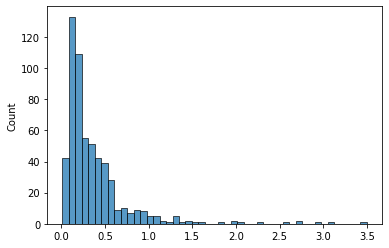

In [75]:
ax = sns.histplot(pimp_fdes)
#ax.set_xscale("log")
print(f"Min: {min(pimp_fdes)} Max: {max(pimp_fdes)}, StdDev:{np.std(pimp_fdes)}")

Min: 1.3657996654510498 Max: 67.80412292480469, StdDev:10.50338783446376


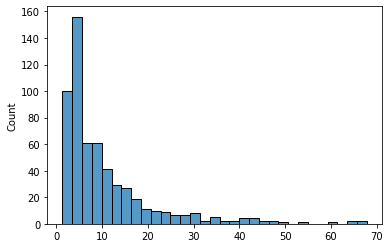

In [76]:
ax = sns.histplot(pimp_ades)
#ax.set_xscale("log")
print(f"Min: {min(pimp_ades)} Max: {max(pimp_ades)}, StdDev:{np.std(pimp_ades)}")

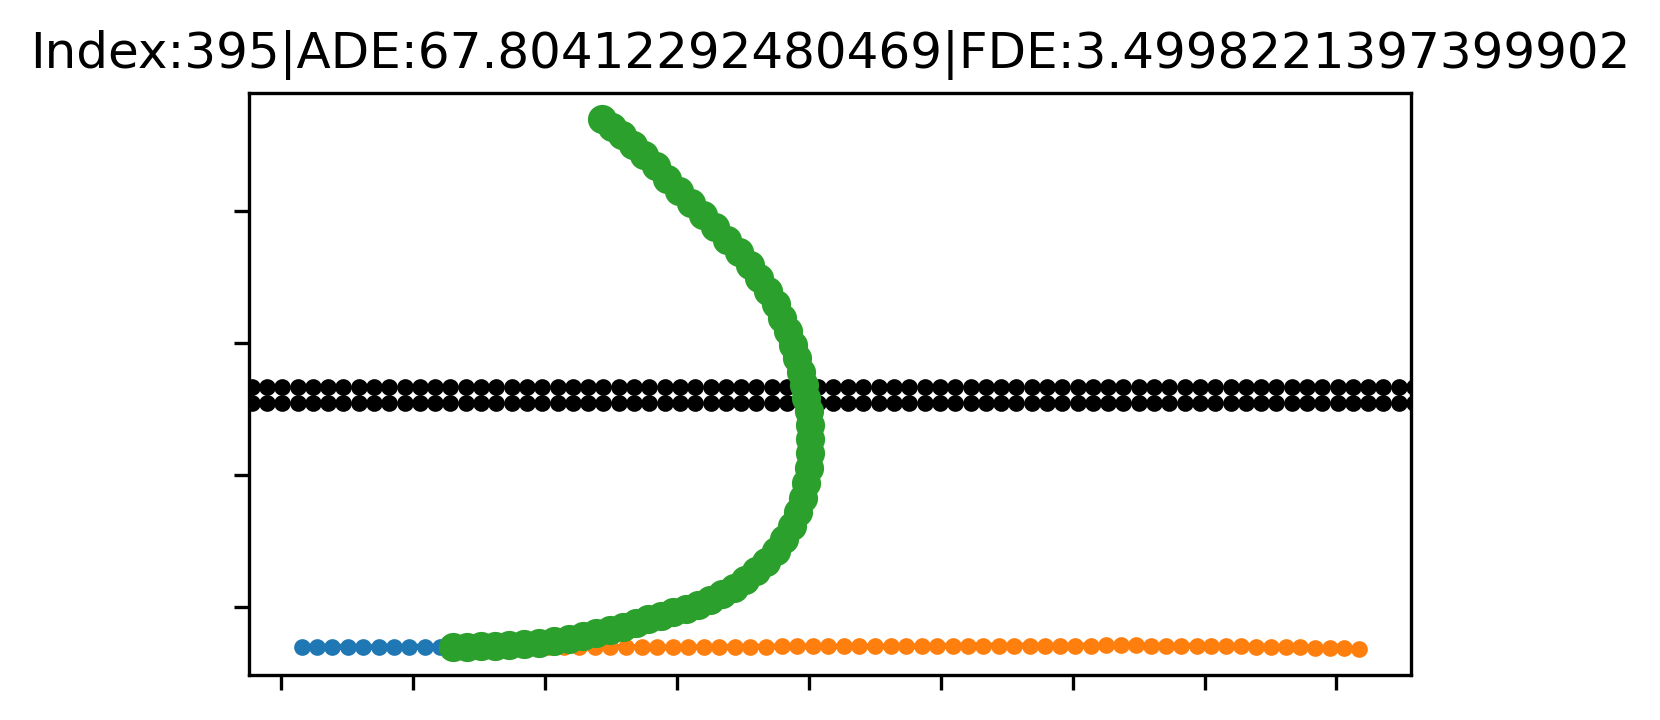

In [77]:
worst_index = np.argmax(pimp_ades)
input, last_pose, target = test_dataset[worst_index]
with torch.no_grad():
    input = input.unsqueeze(0).to(DEVICE)
    last_pose = last_pose.unsqueeze(0)
    target = target.unsqueeze(0).to(DEVICE)
    output = net.predict(input, last_pose)
    loss = custom_loss_func(output, target)
    ade = average_displacement_error(output, target)
    fde = final_displacement_error(output, target)
    plot_single_scenario(input[0], output[0], target[0], title=f"Index:{worst_index}|ADE:{ade}|FDE:{fde}")

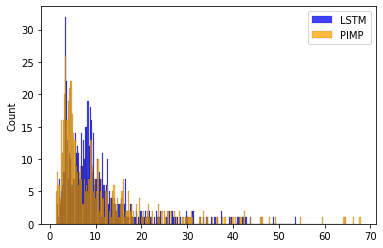

In [86]:
ax = sns.histplot(lstm_ades, label="LSTM", color="Blue", binwidth=0.25)
sns.histplot(pimp_ades,label="PIMP", ax=ax, color="Orange", binwidth=0.25)
ax.legend()

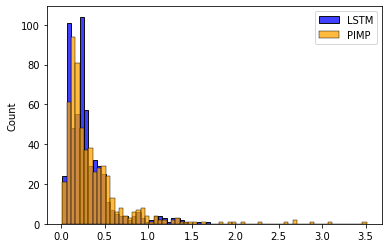

In [83]:
ax = sns.histplot(lstm_fdes, label="LSTM", color="Blue", binwidth=0.05)
sns.histplot(pimp_fdes,label="PIMP", ax=ax, color="Orange", binwidth=0.05)
ax.legend()